<a href="https://colab.research.google.com/github/Batman511/AI-Samsung-Neural-Networks/blob/main/%D0%9A%D1%83%D1%80%D1%81_AI_Samsung_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление функции с помощью нейросети (Регрессия)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

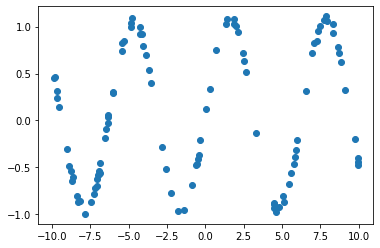

In [21]:
x_train = torch.rand(100)
x_train *=20
x_train -=10

y_train = torch.sin(x_train)
# plt.plot(x_train.numpy(), y_train.numpy(),'o')

noise = torch.rand(y_train.shape)/8.
y_train += noise

plt.plot(x_train.numpy(), y_train.numpy(),'o')

Превращаем вектор признаков в столбец

In [16]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

# Сделаем валидационные данные,   СЛЕДИТЬ ЧТОБЫ БЫЛ ТОТ ЖЕ ДИАПАЗОН, ЧТО В ТРЕНИРОВОЧНЫЕ ДАННЫЕ
x_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(x_valid.data)

x_valid.unsqueeze_(1)
y_valid.unsqueeze_(1);

Создаем Класс нейросети

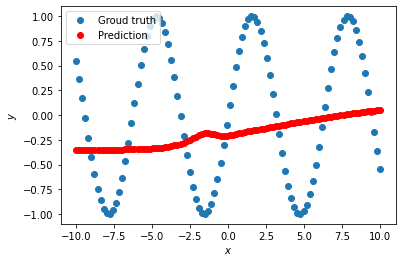

In [18]:
class SinNet(torch.nn.Module):  # наследуем от класса nn.Module
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(SinNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии
# fc - полносвязный слой!
    # последовательное применение слоев, т.е. ИНИЦИАЛИЗАЦИЯ
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sin_net = SinNet(12)

def predict(net,x,y):
    y_pred = net.forward(x)  # предсказываем
    # рисуем
    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sin_net,x_valid,y_valid)

Обучаем нейросеть

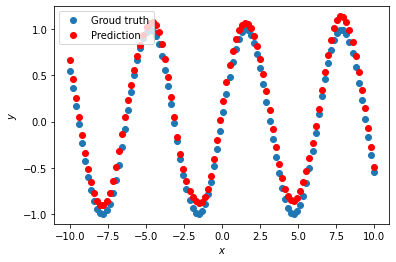

In [19]:
optimazer = torch.optim.Adam(sin_net.parameters(), lr=0.01)  # в parameters() лежат веса нейронов (настроиваемые) поэтому и наследовали
# оптимайзер оборачивает все параметры нейросети

def loss(pred,target):
    sq = (pred-target)**2
    return sq.mean()

for epoch_index in range(2000):
    optimazer.zero_grad()  # зануляем градиенты
    y_pred = sin_net.forward(x_train)
    loss_val = loss(y_pred,y_train)
    loss_val.backward()  # для оптимайзера
    optimazer.step()

predict(sin_net, x_valid, y_valid)

## Вторая функция

In [3]:
import torch

def target_function(x):
    return 2**x * torch.sin(2**-x)

class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(RegressionNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии

    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

net = RegressionNet(30)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:


optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

def loss(pred, target):
    sq = abs(pred-target)
    return sq.mean()

for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = net.forward(x_train)
    loss_value = loss(y_pred, y_train)
    loss_value.backward()
    optimizer.step()

# Проверка:
def metric(pred, target):
   return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.02594063989818096


# Классификация

In [4]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)  # для видеокарты отдельно прописываем
torch.backends.cudnn.deterministic = True

Скачиваем базу с 3 видами вина

In [5]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Создаем выборки и Класс нейросети

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(wine.data[:,:2],  # используем только 2 колонки для визуализации
                                                    wine.target,    # что предсказываем
                                                    test_size=0.3,
                                                    shuffle=True)
# обернем в тензор:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.LongTensor(y_train) # недробные числа
y_test = torch.LongTensor(y_test)

# Нейросеть для классификации
class WineNet(torch.nn.Module):
    # конструктор
    def __init__(self,n_hidden_neurons):
        super(WineNet,self).__init__()

        self.fc1 = torch.nn.Linear(2,n_hidden_neurons)  # 2 входа = 2 колонки
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)  
        self.fc3 = torch.nn.Linear(n_hidden_neurons,3) 
        self.sm = torch.nn.Softmax(dim=1)  # построчное применение

    # граф нейросети
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        return x
# Для подсчета loss softmax не нужен, а для вероятности нужен, поэтому напишем отдельно
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

wine_net = WineNet(5)

# реализация Кроссэнтропии numpy
# def CrossEntropy(y_pred, y_true):
#     total_bce_loss = np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
#     num_of_samples = y_pred.shape[0]
#     mean_bce_loss = total_bce_loss / num_of_samples
#     return mean_bce_loss

# loss = torch.nn.CrossEntropyLoss()   # не работает
# loss = torch.nn.functional.cross_entropy()   # работает

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [29]:
np.random.permutation(5)  # индексы в случайном порядке для перемешивания датасета
batch_size=10

for epoch in range(5000):
    order = np.random.permutation(len(x_train)) # порядок индексов

    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = x_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = wine_net.forward(x_batch)
        loss = torch.nn.functional.cross_entropy(preds,y_batch)
        loss.backward()
        optimizer.step()

    # проверяем каждый 100 эпох как идет обучение (валидационные данные)
    if epoch % 100 == 0:
        test_preds = wine_net.forward(x_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())




tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)


Визуализация результата

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-30-5b03a9fb0f65>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plt.scatter(x_train[indexes, 0],


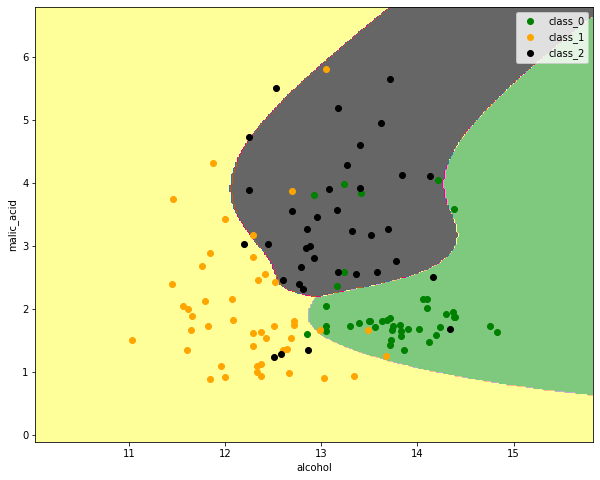

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(x_train[indexes, 0], 
                x_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Если уменьшить число скрытых слоев, качество улучшится

# Классификация рукописных цифр (одномерный тензор)

Обучать следует на GPU (так быстрее)

In [18]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True   # если убрать, то скорость увеличится

Скачиваем картинки рукописных цифр

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

# данные в дробных числах
X_train = X_train.float()
X_test = X_test.float()

In [5]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

Откроем одну картинку

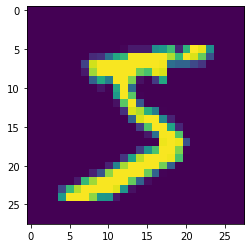

Label:  tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print("Label: ",y_train[0])

Растянем картинки в одномерный тензор

In [7]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

Создаем нейросеть

In [66]:
class MNISTNet(torch.nn.Module):
    def __init__(self,n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
        self.ac1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 

    def forward(self,x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)    
        return x

mnist_net = MNISTNet(100)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)
# torch.nn.functional.cross_entropy()

## Подключаем GPU

In [9]:
print(torch.cuda.is_available())
# !nvidia-smi  # что за видеокарта и занята ли она вычислениями

True


Перекладываем вычисления весов на GPU

In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())  # cuda:0 означаем, что веса лежат на видеокарте

Если памяти хватает, то и данные переносим, но тренировочные перебрасываем батчами

In [68]:
X_test = X_test.to(device)
y_test = y_test.to(device)

## Обучаем

Ставим большое число эпох с рассчетом на что, что сделаем остановку вручную

In [ ]:
batch_size = 128

# для сохрания точности и построения графика
test_accuracy_history = []
test_loss_history = []

for epoch in range(5000):
    order = np.random.permutation(len(X_train))  # на каждой эпохе перемешиваем датасет
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = torch.nn.functional.cross_entropy(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append((torch.nn.functional.cross_entropy(test_preds, y_test)).data.detach().cpu().numpy())  # следим за качеством
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()  # argmax отдаст номер нейрона с наибольшей вероятностью
    test_accuracy_history.append(accuracy.detach().cpu().numpy())   # следим за качеством
    print(accuracy)

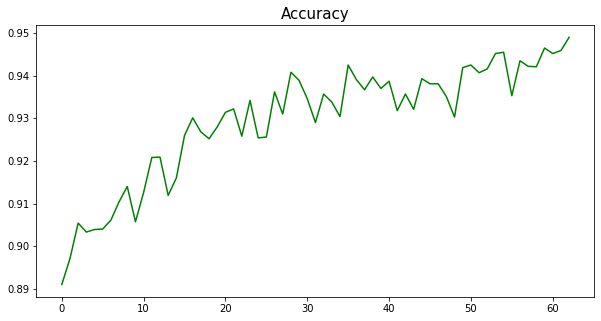

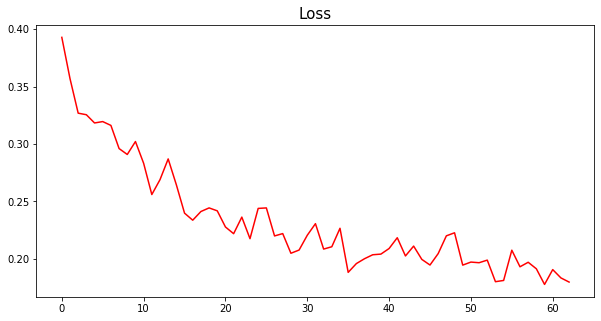

In [70]:
fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Accuracy", fontsize=15)
ax_real.plot(test_accuracy_history, c='green')

fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Loss", fontsize=15)
ax_real.plot(test_loss_history, c='red')

# Классификация рукописных цифр (сверточные нейронные сети)

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True   # если убрать, то скорость увеличится

Скачиваем картинки рукописных цифр

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

# данные в дробных числах
X_train = X_train.float()
X_test = X_test.float()

In [5]:
print("Старая размерность: ",X_train.shape, X_test.shape)

# доьавляем еще одно измерение
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
print("Новая размерность: ",X_train.shape, X_test.shape)

Старая размерность:  torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
Новая размерность:  torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


Создаем класс нейросети

In [6]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # после 1 слоя хотим сохранить размер 28х28, добавляем паддинг
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,padding=2)  # bias=False
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,padding=0)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)   

        # растянем в один вектор потом

        self.fc1 = torch.nn.Linear(5*5*16, 120)  # сколько нейронов на входе, на выходе
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    # применяем слои к входному вектору
    def forward(self,x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool2(x)

        # растянем 4х мерный тензор в двумерный
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)

        return x

lenet5 = LeNet5()

Подключим GPU и выберем оптимайзер и loss функцию

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обнуляем градиент
        optimizer.zero_grad()
        
        # выбираем какие картинки войдут в батч
        batch_indexes = order[start_index:start_index+batch_size]
        
        # отправляем батч на GPU
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # пропускаем батч через forward
        preds = lenet5.forward(X_batch) 
        
        # считаем ошибку, градиенты и делаем шаг град.спуска
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # следим за качеством
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())   # пишем .data чтобы не хранить все вычисления, а только числа
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

Графики

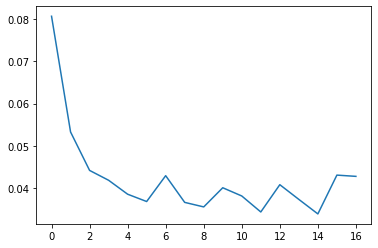

In [14]:
# plt.plot(test_accuracy_history);
# plt.plot(test_loss_history);

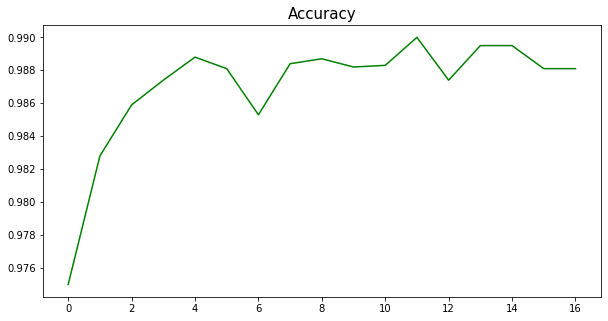

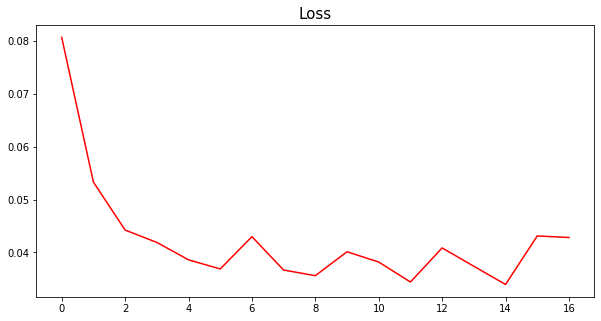

In [15]:
fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Accuracy", fontsize=15)
ax_real.plot(test_accuracy_history, c='green')

fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Loss", fontsize=15)
ax_real.plot(test_loss_history, c='red')

# Новый раздел